# Урок 7. Классификация с помощью KNN. Кластеризация K-means

In [10]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

**1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов соседей по любому из показанных на уроке принципов.**

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

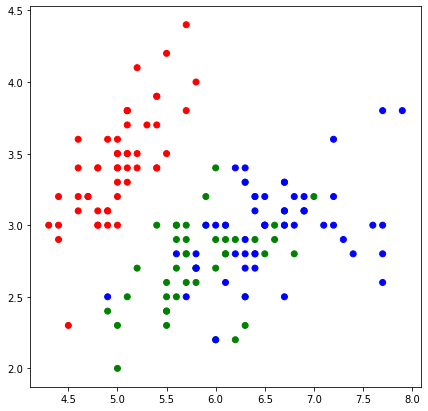

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [4]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
      
    return np.sqrt(distance)

In [5]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [6]:
def knn(x_train, y_train, x_test, k, weight_type):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append([distance, y_train[i]])
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список
        srt = sorted(test_distances)[0:k]
        for d in srt:
            if weight_type == 'distance':
                  d.append((1/2)**d[0])
            elif weight_type == 'index':
                d.append(1/(srt.index(d) + 1))
            else:
                pass

        # Cреди первых k элементов подсчитаем частоту появления разных классов
        for d in srt:
            classes[d[1]] += d[2]
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [7]:
def get_graph(X_train, y_train, k, weight, axes_counter, acc):
    axi = ax.flatten()[axes_counter]
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .05

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, weight)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    axi.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    axi.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    axi.set_xlim(xx.min(), xx.max())
    axi.set_ylim(yy.min(), yy.max())
    axi.set_title(f"k = {k}, weights = {weight}, accuracy = {round(acc, 2)}")

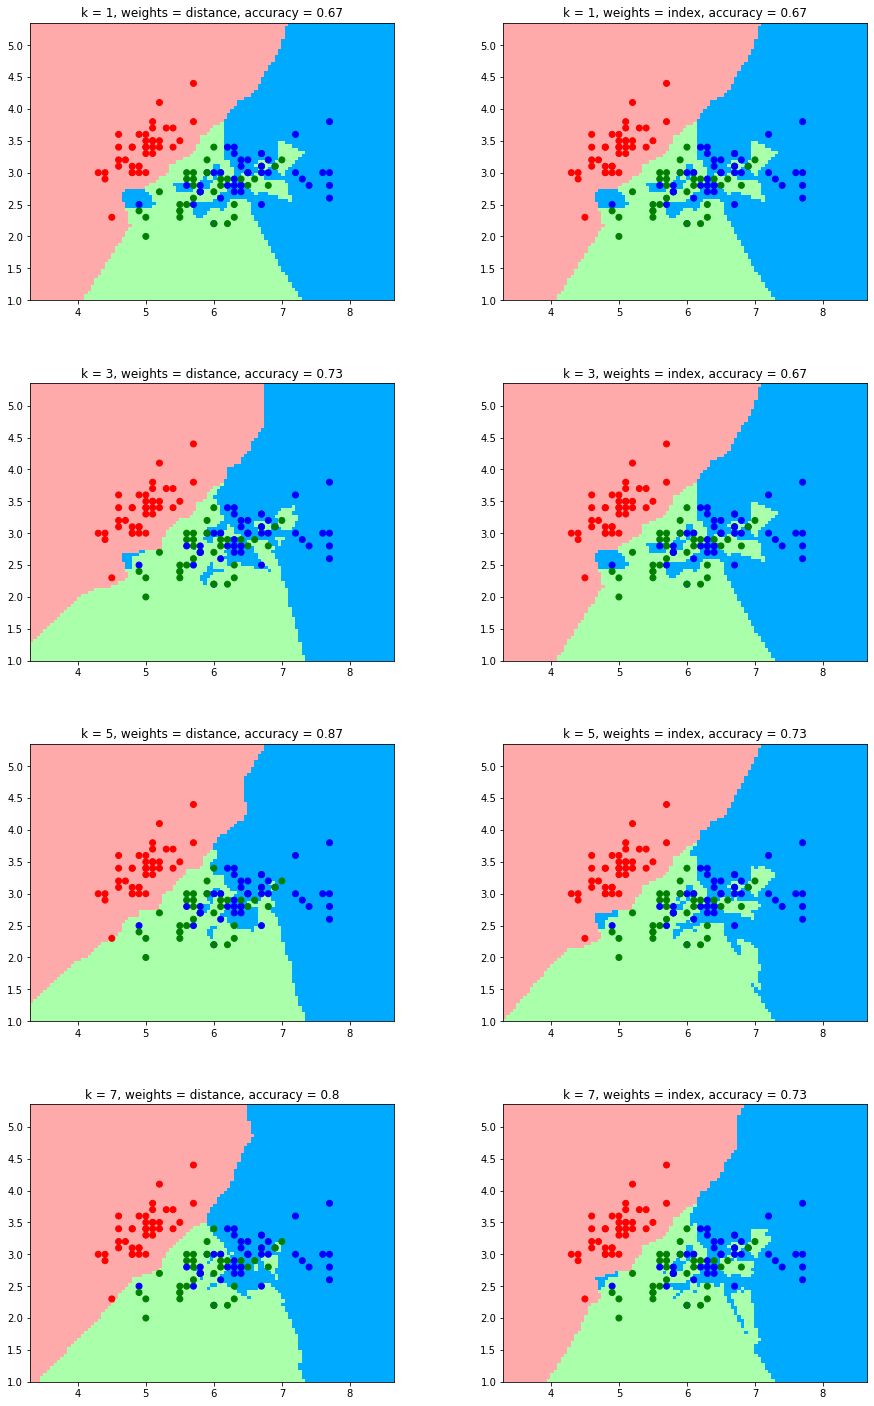

In [8]:
kk = [1, 3, 5, 7]
rows = len(kk)

fig, ax = plt.subplots(nrows = rows, ncols = 2)
fig.set_size_inches(15, 25)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

axes_counter = 0
for k in kk:
    for weight in ['distance', 'index']:
        y_pred = knn(X_train, y_train, X_test, k, weight)
        acc = accuracy(y_pred, y_test)
        get_graph(X_train, y_train, k, weight, axes_counter, acc)
        axes_counter +=1

Лучший результат (accuracy=0.87) наблюдается для количества соседей k=5 с весами, зависящими от расстояния до классифицируемого объекта

**2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от k (взять от 1 до 10) для выборки данных из данного урока.**

In [13]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [14]:
def inner_dist(centroids, clusters):
    dists = [np.array([e_metrics(x, centroids[key]) ** 2 for x in clusters[key]]).sum() / len(clusters[key]) for key in clusters.keys()]
    inner_dist = np.array(dists).sum()
    
    return inner_dist

In [15]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [30]:
X, y = make_blobs(n_samples=100, random_state=42)

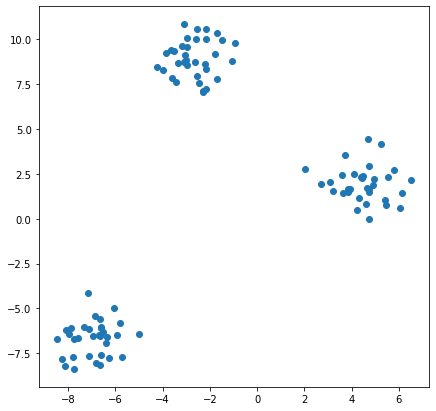

In [31]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [32]:
max_iterations = 10
min_distance = 1e-4

In [33]:
dist = []
for k in range(1, 11):
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    dist.append(inner_dist(centroids, clusters))

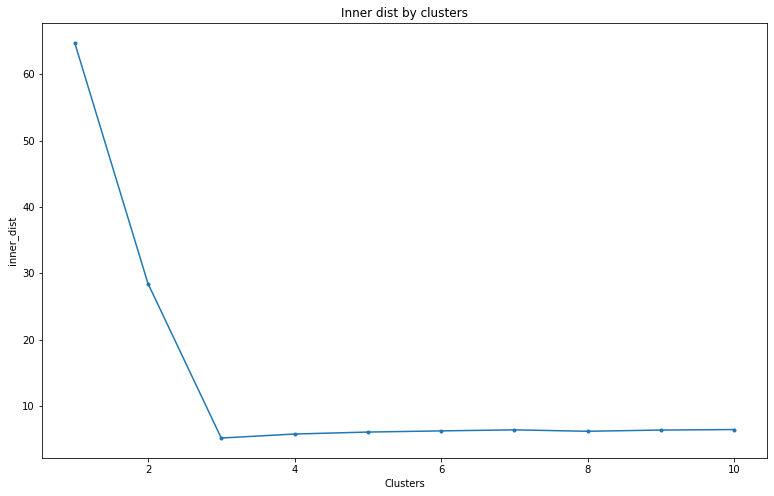

In [34]:
plt.figure(figsize=(13, 8))
plt.title('Inner dist by clusters')
plt.xlabel('Clusters')
plt.ylabel('inner_dist')

plt.plot(range(1, 11), dist, marker = '.')


plt.show()

In [35]:
min_dist = min(dist)
print(f'Min inner dist = {min_dist}, number of clusters = {dist.index(min_dist) + 1}')

Min inner dist = 5.157839037244711, number of clusters = 3
